In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import tensorflow as tf
import h5py

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, Reshape, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.utils import to_categorical

Using TensorFlow backend.


##### Training data

In [3]:
def get_class_data(class_name):
    global class_counts
    
    path = os.path.join(train_path, class_name)
    class_units = np.fromfile(path, dtype=int, count=-1, sep=' ', offset=0)
    units = np.split(class_units, class_units.size // 1080, 0) # 1080 = 3 sec * 360Hz
    class_counts[class_name] = class_units.size // 1080
   
    return units

In [6]:
base_path = 'C:\\cygwin\\home\\User\\1studing\\wfdb\\GettingData\\cnn_code'
model_save_path = os.path.join(base_path, 'model\\cnn_model.h5') 
model_weights_path = os.path.join(base_path, 'model\\cnn_model_weights.hdf5')

train_path = os.path.join(base_path, 'data_files')

classes = ['N', 'LBBB', 'RBBB', 'B', 'T', 'VT', 'SVTA', 'AFIB', 'AFL', 'NOD', 'IVR', 'V']
class_mapping = {'N': 0, 'LBBB': 1, 'RBBB': 2, 'B': 3, 'T': 4, 'VT': 5, 'SVTA': 6, 'AFIB': 7, 'AFL': 8, 'NOD': 9, 'IVR': 10, 'V': 11}
class_counts = {'N': 0, 'LBBB': 0, 'RBBB': 0, 'B': 0, 'T': 0, 'VT': 0, 'SVTA': 0, 'AFIB': 0, 'AFL': 0, 'NOD': 0, 'IVR': 0, 'V': 0}

X_train = [] # data - each unit 3 sec - 1080 values
Y_train = [] #labels - from class_mapping

for class_i in classes:
    class_units = get_class_data(class_i)
    Y_train  += [class_mapping[class_i]] * class_counts[class_i]
    X_train += class_units

#print(len(X_train)) #8079
#print(len(Y_train)) #8079

##### Building the model

In [30]:
TIME_PERIODS = 1080

num_classes = 12
input_shape = None

model = Sequential()
model.add(Reshape((TIME_PERIODS, 1), input_shape=(input_shape,)))  
model.add(Conv1D(50, 5, activation='relu', input_shape=(TIME_PERIODS, 1))) # n_timesteps,n_features  OK
model.add(Conv1D(50, 5, activation='relu')) 
#model.add(Dropout(0.5))
#model.add(Conv1D(100, 10, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(100, 5, activation='relu'))
#model.add(Dropout(0.3))
model.add(Conv1D(100, 5, activation='relu'))
#model.add(Dropout(0.5))
model.add(GlobalAveragePooling1D())
#model.add(GlobalMaxPooling1D())
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

print(model.summary())

model.save(model_save_path)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 1080, 1)           0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 1076, 50)          300       
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 1072, 50)          12550     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 536, 50)           0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 532, 100)          25100     
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 528, 100)          50100     
_________________________________________________________________
global_average_pooling1d_10  (None, 100)             

##### Training


--- Fit the model ---

Train on 8079 samples
Epoch 1/10
8079/8079 [==============================] - 61s 7ms/sample - loss: 4.5438 - accuracy: 0.4402
Epoch 2/10
8079/8079 [==============================] - 63s 8ms/sample - loss: 1.5621 - accuracy: 0.5157
Epoch 3/10
8079/8079 [==============================] - 62s 8ms/sample - loss: 1.5271 - accuracy: 0.5256
Epoch 4/10
8079/8079 [==============================] - 66s 8ms/sample - loss: 1.4987 - accuracy: 0.5325
Epoch 5/10
8079/8079 [==============================] - 69s 9ms/sample - loss: 1.4645 - accuracy: 0.5331
Epoch 6/10
8079/8079 [==============================] - 64s 8ms/sample - loss: 1.4255 - accuracy: 0.5331
Epoch 7/10
8079/8079 [==============================] - 60s 7ms/sample - loss: 1.3704 - accuracy: 0.5368
Epoch 8/10
8079/8079 [==============================] - 65s 8ms/sample - loss: 1.3421 - accuracy: 0.5382
Epoch 9/10
8079/8079 [==============================] - 65s 8ms/sample - loss: 1.3152 - accuracy: 0.5511
Epoch 10/

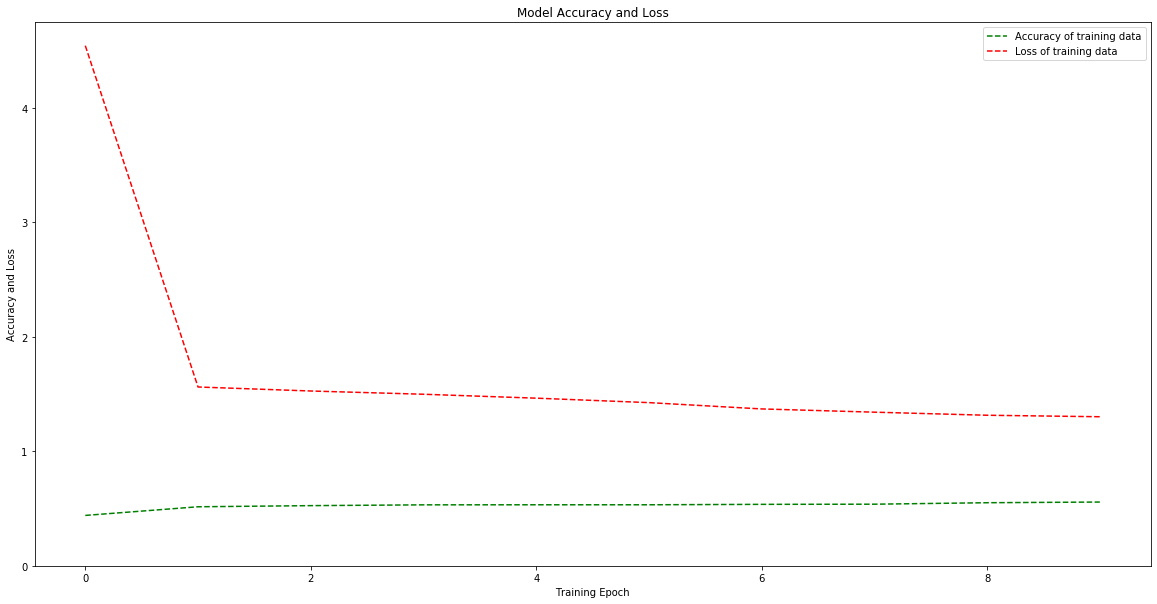

In [31]:
XX_train = np.asarray(X_train)
YY_train = np.asarray(Y_train)
XX_train = XX_train.astype("float32")
YY_train = YY_train.astype("float32")

YY_train = to_categorical(YY_train, num_classes)

print("\n--- Fit the model ---\n")

# Hyper-parameters
BATCH_SIZE = 90
EPOCHS = 10

history = model.fit(XX_train,
                      YY_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1)  

model.save_weights(model_weights_path)


print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(20, 10)) 
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
model.save(model_save_path)

In [26]:
def get_class_data_test(class_name):
    global class_counts_test
    
    path_test = os.path.join(test_path, class_name)
    class_units_test = np.fromfile(path_test, dtype=int, count=-1, sep=' ', offset=0)
    units_test = np.split(class_units_test, class_units_test.size // 1080, 0) # 1080 = 3 sec * 360Hz
    class_counts_test[class_name] = class_units_test.size // 1080

    
    return units_test

In [28]:
test_path = os.path.join(base_path, 'data_files_test')
class_counts_test = {'N': 0, 'LBBB': 0, 'RBBB': 0, 'B': 0, 'T': 0, 'VT': 0, 'SVTA': 0, 'AFIB': 0, 'AFL': 0, 'NOD': 0, 'IVR': 0, 'V': 0}

X_test = []
Y_test = []

for class_i in classes:
    class_units_test = get_class_data_test(class_i)
    Y_test  += [class_mapping[class_i]] * class_counts_test[class_i]
    X_test += class_units_test
    
print(len(Y_test))

7926


In [29]:
XX_test = np.asarray(X_test)
YY_test = np.asarray(Y_test)
XX_test = XX_test.astype("float32")
YY_test = YY_test.astype("float32")

YY_test = to_categorical(YY_test, num_classes)

model_test = model

#model_test = load_model(model_save_path)
#model_test.load_weights(model_weights_path) 

BATCH_SIZE = 90

score = model_test.evaluate(XX_test, YY_test, batch_size = BATCH_SIZE, verbose=2)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

7926/1 - 198s - loss: 2.4797 - accuracy: 0.4817

Accuracy on test data: 0.48

Loss on test data: 2.09
